In [1]:
print("importing modules")
import torch
import utilities
print("done")

importing modules
done


Load the MNIST data

In [2]:

data_dict = torch.load("MNIST_images_size_256")
images = data_dict["images"]
labels = data_dict["labels"]
BATCH_SIZE = data_dict["BATCH_SIZE"]


C:\Users\Josh\AppData\Local\Temp\ipykernel_13852\860611989.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load("MNIST_images_size_256")


Original dataset is already centered at the center of brightness, so we will add some noise to show how the SVD decreases as if they were not centered

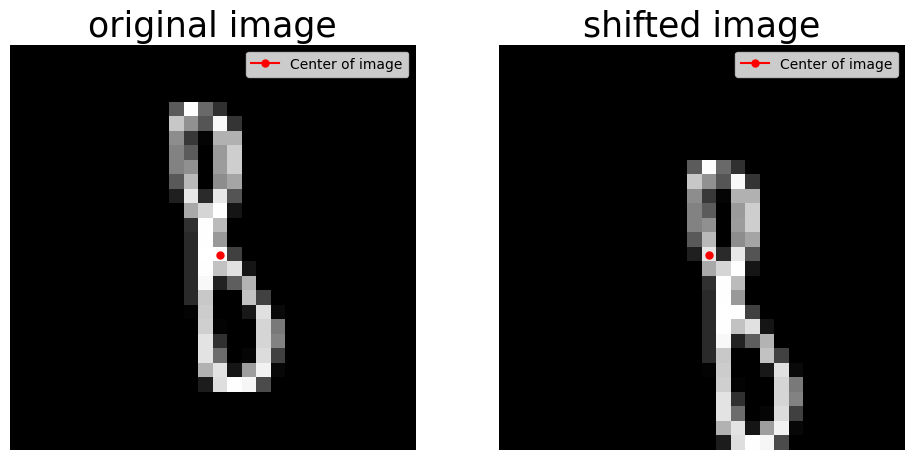

In [3]:
rshifted_images = []
for image in images:
    rshifted_images.append(utilities.shift(image, torch.rand(2)*5))
    
rshifted_images = torch.stack(rshifted_images)

utilities.graph_images([images[4],rshifted_images[4]],labels=["original image", "shifted image"], graph_centers=True, figure_size=100)

Start translating the images


computed center of brightness: tensor([13.9450, 13.5896])


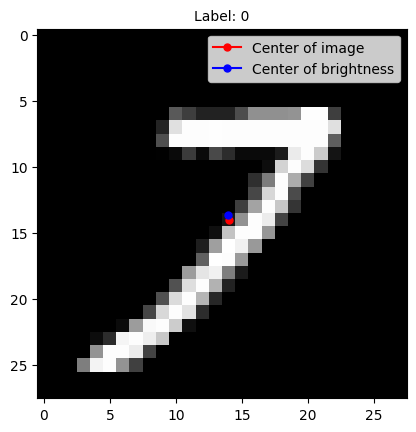

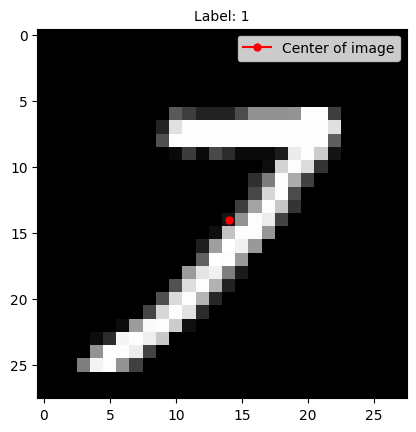

In [4]:
center_of_brightness = utilities.find_center_of_brightness(image)
print("computed center of brightness: " + str(center_of_brightness))

recentered_image = utilities.recenter(image, center_of_brightness)
utilities.graph_image(image, label=torch.tensor([0]), graph_center=True, graph_point = center_of_brightness)
utilities.graph_image(recentered_image, label=torch.tensor([1]), graph_center=True)

Apply transformation to all images

In [5]:
centering_func = lambda img: utilities.recenter(img, utilities.find_center_of_brightness(img))

In [6]:
recentered_images = []
for image in images:
    recentered_images.append(centering_func(image))

recentered_images = torch.stack(recentered_images)

Preform SVD decomposition on the noisy data and the recentered data

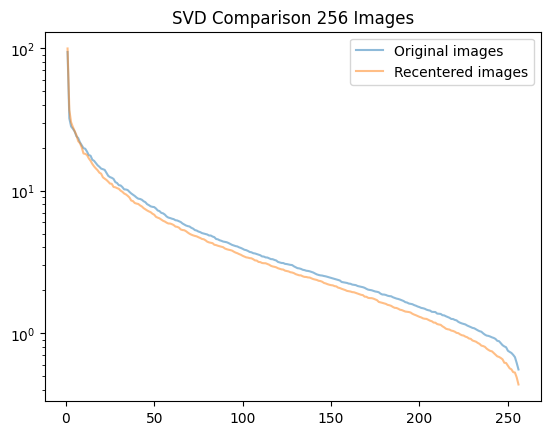

In [7]:
osvds = utilities.get_SVD_vals(rshifted_images)
svdr=utilities.get_SVD_vals(recentered_images)
utilities.graph_SVDs([osvds, svdr], ["Original images", "Recentered images"],title="SVD Comparison 256 Images")

Analyze Feature Matrix

In [26]:
U,S,V = utilities.get_SVD_decomp(recentered_images)

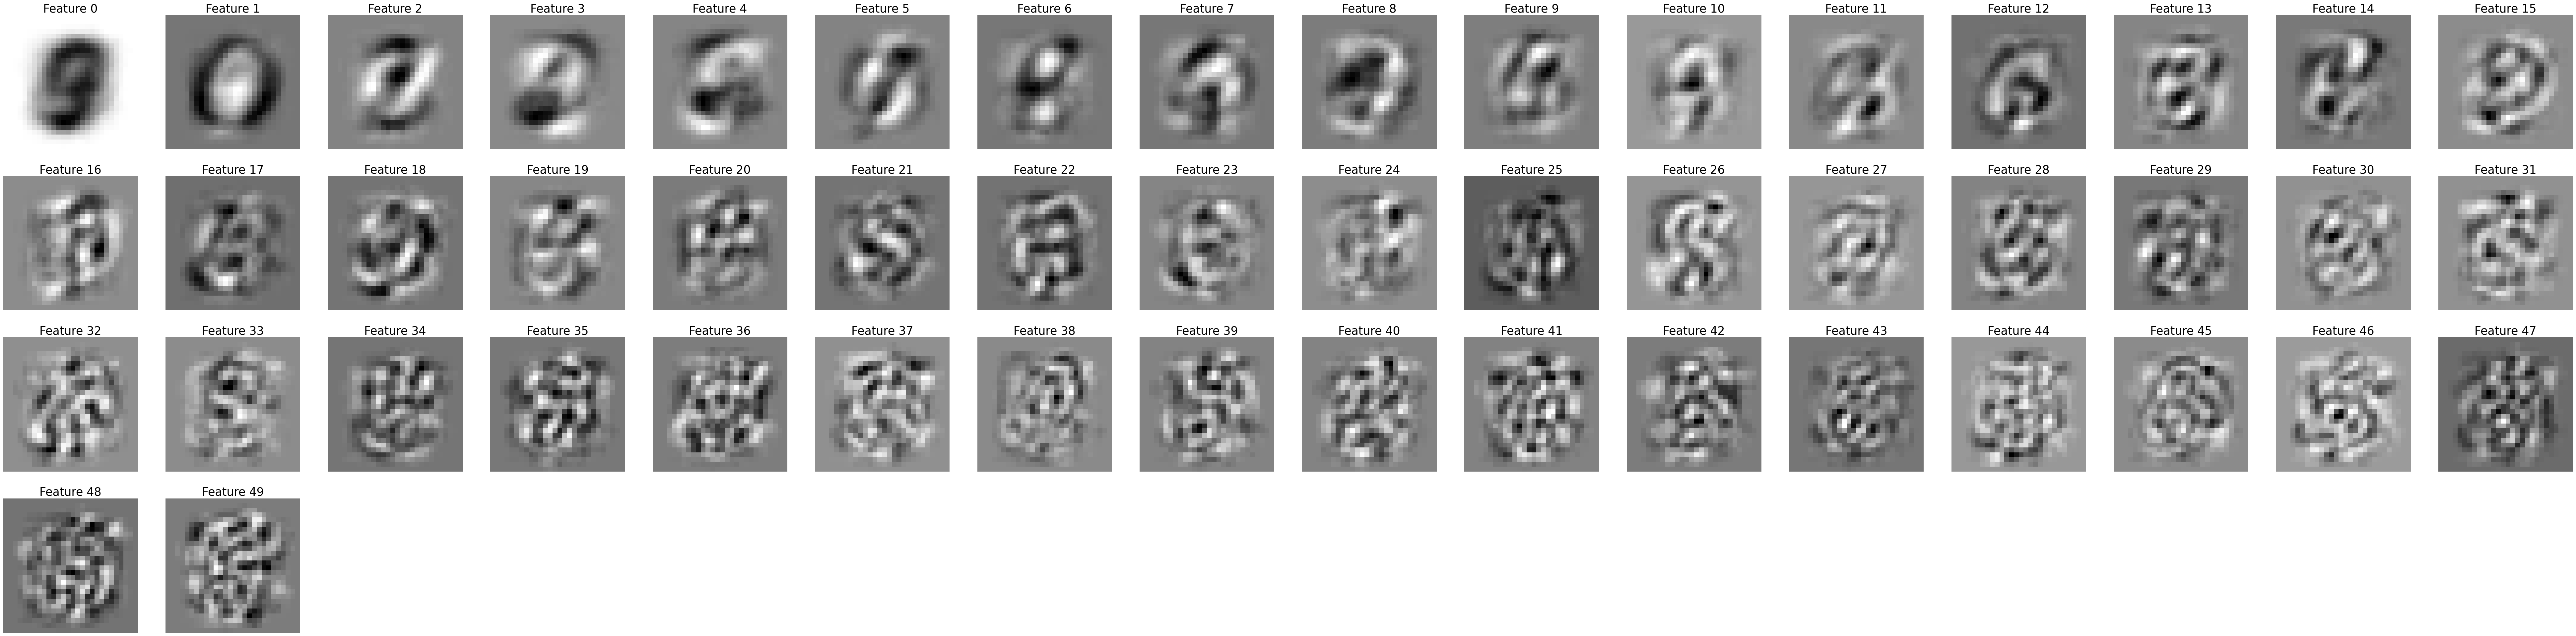

In [27]:
V = torch.from_numpy(V)
features = V[:50]
utilities.graph_images(features.reshape(-1,28,28).unsqueeze(1), labels=[f"Feature {i}" for i in range(features.size(0))])

In [ ]:
VT = V.T
approxfn = lambda n, image: (V[:n].T @ V[:n] @ image.flatten()).reshape(28,28).unsqueeze(0)

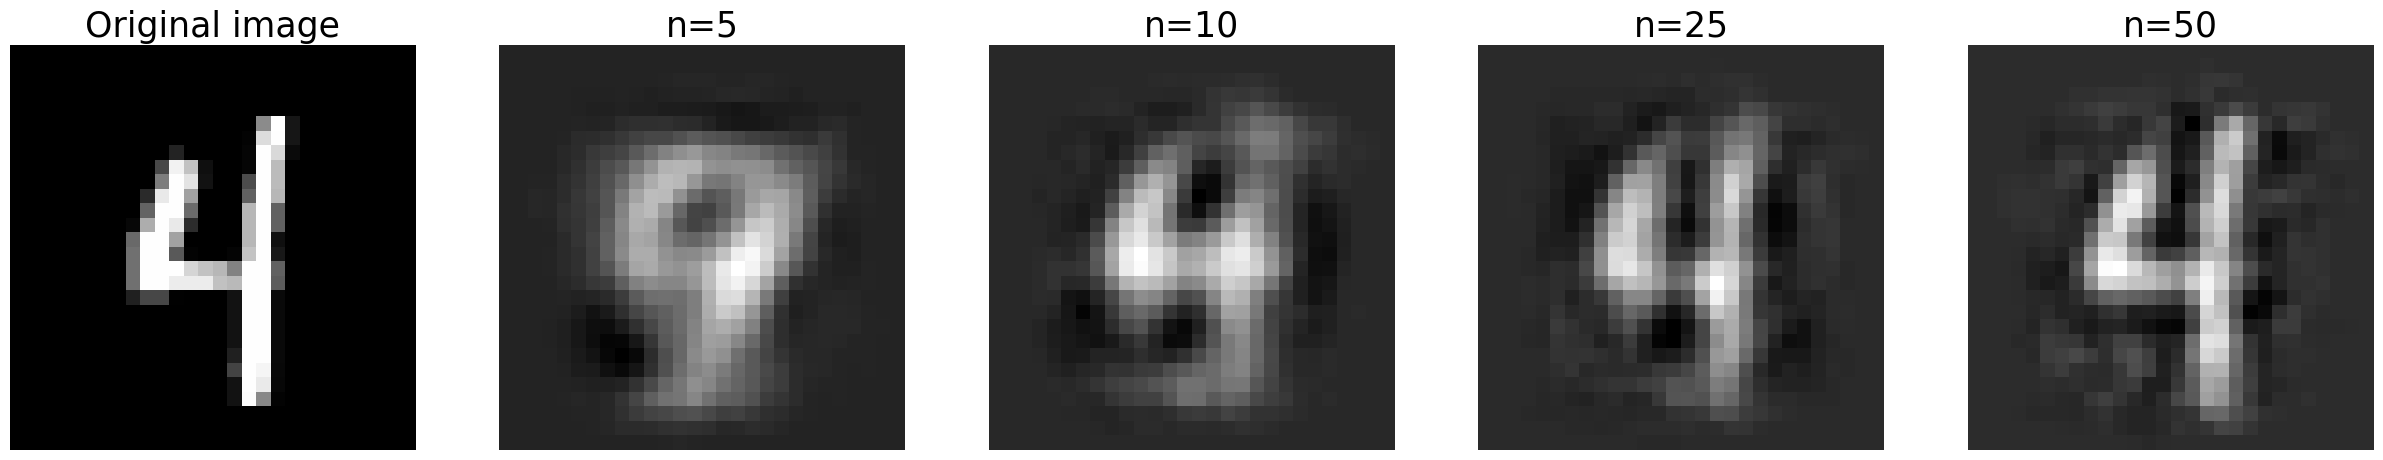

In [ ]:
utilities.graph_images([recentered_images[0], 
                        approxfn(5, recentered_images[0]), 
                        approxfn(10, recentered_images[0]), 
                        approxfn(25, recentered_images[0]), 
                        approxfn(50, recentered_images[0])
                        ], 
                       labels= ["Original image", "n=5", "n=10", "n=25", "n=50"]
                       )